# 서울시 편의점 매출 결정요인 분석

---

## Executive Summary

본 프로젝트는 서울시 편의점 매출을 결정하는 핵심 요인을 데이터 기반으로 분석하여,  
**신규 출점 입지 선정** 및 **기존 점포 운영 전략** 수립에 활용할 수 있는 인사이트를 도출합니다.

### 핵심 발견
- **상권유형**이 매출에 가장 큰 영향 (관광특구 > 발달상권 > 전통시장 > 골목상권)
- **점포수**와 **유동인구**가 매출과 강한 양의 상관관계
- 머신러닝 모델(RandomForest)이 매출 예측에서 R²=0.86 달성

### 분석 흐름
```
1. 프로젝트 개요 → 2. 데이터 소개 → 3. EDA/가설검증 → 4. 회귀분석 
→ 5. 머신러닝 예측 → 6. What-if 시나리오 → 7. 인사이트 → 8. 결론/제언
```

---

# 1. 프로젝트 개요

## 1.1 주제 선정 이유

편의점 출점·운영 판단이 현장에서는 **"사람 많아 보인다"** 같은 경험/감각에 의존하는 경우가 많습니다.  
그런데 실제 매출은 유동인구 외에도 점포 밀집도, 상권 성격 등 여러 요인이 동시에 작동하므로,  
**무엇이 더 중요한지 정량 근거로 설명할 필요**가 있습니다.

> 본 분석은 데이터 기반으로 매출 결정 요인을 검증하고,  
> 신규 출점 및 기존 점포 운영에 활용할 수 있는 인사이트를 도출합니다.

## 1.2 연구 질문

**"서울시 편의점 매출을 결정하는 핵심 요인은 무엇인가?"**

## 1.3 가설 설정

| 가설 | 내용 | 검증방법 |
|------|------|----------|
| **H1** | 유동인구가 많을수록 매출이 높다 | 상관분석, 회귀분석 |
| **H2** | 점포수(밀집도)가 높을수록 매출이 높다 | 상관분석, 회귀분석 |
| **H3** | 상권유형은 매출에 유의한 영향이 있다 | 회귀분석 (더미변수) |
| **H4** | 상권유형 간 평균 매출 차이가 있다 | ANOVA + Tukey HSD |

> ※ **사전 점검**: 유동인구 ↔ 점포수 간 다중공선성 → VIF 분석으로 확인

---

# 2. 환경 설정 및 데이터 로드

In [2]:
# ============================================================
# 필수 라이브러리 로드
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.datasets import load_iris
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# 시각화 한글 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 출력 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

# 출력 폴더 생성
import os
os.makedirs('./outputs', exist_ok=True)
os.makedirs('./data/raw', exist_ok=True)
os.makedirs('./data/processed', exist_ok=True)

print("환경 설정 완료 ✓")
print("\n필요 폴더 구조:")
print("  ./data/raw/         - Raw 데이터 파일")
print("  ./data/processed/   - 전처리 완료 데이터")
print("  ./outputs/          - 분석 결과물")

환경 설정 완료 ✓

필요 폴더 구조:
  ./data/raw/         - Raw 데이터 파일
  ./data/processed/   - 전처리 완료 데이터
  ./outputs/          - 분석 결과물


# 3. Raw 데이터 로드 및 전처리

---

## 3.1 데이터 소스 확인

**가설 검증에 필요한 변수:**

| 변수 | 역할 | 데이터 파일 |
|------|------|-------------|
| 당월_매출_금액 | 종속변수 (Y) | sales.csv |
| 총_유동인구_수 | 독립변수 (X1) | population.csv |
| 점포_수 | 독립변수 (X2) | stores.csv |
| 주요_상권유형 | 독립변수 (X3) | districts.csv |

**데이터 출처**: 서울 열린데이터광장 - 서울시 우리마을가게 상권분석서비스

In [3]:
# ============================================================
# Raw 데이터 로드
# ============================================================
# 데이터 파일 위치: ./data/raw/
# ============================================================

RAW_PATH = './data/raw/'

sales_df = pd.read_csv(RAW_PATH + 'sales.csv', encoding='utf-8-sig')
store_df = pd.read_csv(RAW_PATH + 'stores.csv', encoding='utf-8-sig')
pop_df = pd.read_csv(RAW_PATH + 'population.csv', encoding='utf-8-sig')
area_df = pd.read_csv(RAW_PATH + 'districts.csv', encoding='cp949')

print("=" * 70)
print("Raw 데이터 로드 완료")
print("=" * 70)
print(f"\n  매출 데이터:     {sales_df.shape[0]:>10,}건 × {sales_df.shape[1]}개 컬럼")
print(f"  점포 데이터:     {store_df.shape[0]:>10,}건 × {store_df.shape[1]}개 컬럼")
print(f"  유동인구 데이터: {pop_df.shape[0]:>10,}건 × {pop_df.shape[1]}개 컬럼")
print(f"  상권영역 데이터: {area_df.shape[0]:>10,}건 × {area_df.shape[1]}개 컬럼")

Raw 데이터 로드 완료

  매출 데이터:        256,378건 × 53개 컬럼
  점포 데이터:        528,758건 × 12개 컬럼
  유동인구 데이터:     11,475건 × 25개 컬럼
  상권영역 데이터:      1,650건 × 11개 컬럼


## 3.1 데이터 구조 및 타입 확인

In [4]:
# ============================================================
# 데이터 구조 확인
# ============================================================

datasets = {'매출': sales_df, '점포': store_df, '유동인구': pop_df, '상권영역': area_df}

for name, df_temp in datasets.items():
    print("=" * 70)
    print(f"[{name} 데이터]")
    print("=" * 70)
    print(f"크기: {df_temp.shape[0]:,}행 × {df_temp.shape[1]}열")
    print(f"\n컬럼: {list(df_temp.columns)}")
    print(f"\n데이터 타입:")
    print(df_temp.dtypes)
    print()

[매출 데이터]
크기: 256,378행 × 53열

컬럼: ['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '서비스_업종_코드', '서비스_업종_코드_명', '당월_매출_금액', '당월_매출_건수', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수', '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수', '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수', '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수', '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '남성_매출_건수', '여성_매출_건수', '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수', '연령대_40_매출_건수', '연령대_50_매출_건수', '연령대_60_이상_매출_건수']

데이터 타입:
기준_년분기_코드            int64
행정동_코드               int64
행정동_코드_명            object
서비스_업종_코드           object
서비스_업종_코드_명         object
당월_매출_금액           float64
당월_매

## 3.2 결측치 확인

In [5]:
# ============================================================
# 결측치 확인
# ============================================================

print("=" * 70)
print("결측치 현황")
print("=" * 70)

for name, df_temp in datasets.items():
    missing = df_temp.isnull().sum()
    print(f"\n[{name} 데이터]")
    if missing.sum() == 0:
        print("  → 결측치 없음 ✓")
    else:
        for col in missing[missing > 0].index:
            print(f"  {col}: {missing[col]:,}건")

결측치 현황

[매출 데이터]
  → 결측치 없음 ✓

[점포 데이터]
  → 결측치 없음 ✓

[유동인구 데이터]
  → 결측치 없음 ✓

[상권영역 데이터]
  → 결측치 없음 ✓


## 3.3 기본 통계 확인

In [6]:
# ============================================================
# 기본 통계 확인
# ============================================================

print("[매출 데이터 - 주요 수치형 변수]")
display(sales_df[['당월_매출_금액', '당월_매출_건수']].describe())

print("\n[점포 데이터]")
display(store_df[['점포_수']].describe())

print("\n[유동인구 데이터]")
display(pop_df[['총_유동인구_수']].describe())

[매출 데이터 - 주요 수치형 변수]


,당월_매출_금액,당월_매출_건수
count,"256,378.00","256,378.00"
mean,"1,501,606,491.49","54,303.94"
std,"10,527,250,166.39","242,736.13"
min,52.00,1.00
25%,"67,019,402.50","1,021.25"
50%,"272,240,290.50","5,607.00"
75%,"956,284,022.50","30,599.50"
max,"866,400,000,000.00","31,339,206.00"



[점포 데이터]


,점포_수
count,"528,758.00"
mean,16.87
std,73.54
min,0.00
25%,3.00
50%,6.00
75%,15.00
max,"10,649.00"



[유동인구 데이터]


,총_유동인구_수
count,"11,475.00"
mean,"5,598,699.89"
std,"2,983,157.63"
min,"7,864.00"
25%,"3,494,591.50"
50%,"5,302,422.00"
75%,"7,029,637.00"
max,"23,188,491.00"


## 3.4 분석 범위 설정 (불필요 데이터 제거)

**필터링 조건:**
- 업종: **편의점만** (서비스_업종_코드 = 'CS300002')
- 기간: **2022년 1분기 ~ 2025년 3분기** (15개 분기)

In [7]:
# ============================================================
# 분석 범위 설정 (필터링)
# ============================================================

print("=" * 70)
print("분석 범위 설정")
print("=" * 70)

# 편의점만 필터링
cvs_sales = sales_df[sales_df['서비스_업종_코드'] == 'CS300002'].copy()
cvs_store = store_df[store_df['서비스_업종_코드'] == 'CS300002'].copy()

print(f"\n[업종 필터링 - 편의점만]")
print(f"  매출: {len(sales_df):,} → {len(cvs_sales):,}건")
print(f"  점포: {len(store_df):,} → {len(cvs_store):,}건")

# 기간 필터링
cvs_sales = cvs_sales[(cvs_sales['기준_년분기_코드'] >= 20221) & (cvs_sales['기준_년분기_코드'] <= 20253)]
cvs_store = cvs_store[(cvs_store['기준_년분기_코드'] >= 20221) & (cvs_store['기준_년분기_코드'] <= 20253)]
pop_filtered = pop_df[(pop_df['기준_년분기_코드'] >= 20221) & (pop_df['기준_년분기_코드'] <= 20253)].copy()

print(f"\n[기간 필터링 - 2022Q1~2025Q3]")
print(f"  매출: {len(cvs_sales):,}건")
print(f"  점포: {len(cvs_store):,}건")
print(f"  유동인구: {len(pop_filtered):,}건")

분석 범위 설정



[업종 필터링 - 편의점만]
  매출: 256,378 → 6,097건
  점포: 528,758 → 6,375건

[기간 필터링 - 2022Q1~2025Q3]
  매출: 6,097건
  점포: 6,375건
  유동인구: 6,375건


## 3.5 텍스트 처리 (인코딩 수정)

행정동명의 '?' 문자를 '·'로 복원 (예: 종로1?2?3?4가동 → 종로1·2·3·4가동)

In [8]:
# ============================================================
# 텍스트 처리 (인코딩 수정)
# ============================================================

problem_count = cvs_sales['행정동_코드_명'].str.contains('\\?', regex=True).sum()
print(f"수정 전 '?' 포함 행: {problem_count}건")

cvs_sales['행정동_코드_명'] = cvs_sales['행정동_코드_명'].str.replace('?', '·', regex=False)
cvs_store['행정동_코드_명'] = cvs_store['행정동_코드_명'].str.replace('?', '·', regex=False)
pop_filtered['행정동_코드_명'] = pop_filtered['행정동_코드_명'].str.replace('?', '·', regex=False)
area_df['행정동_코드_명'] = area_df['행정동_코드_명'].str.replace('?', '·', regex=False)

print(f"→ 인코딩 수정 완료 ✓")

수정 전 '?' 포함 행: 21건
→ 인코딩 수정 완료 ✓


## 3.6 범주형 데이터 처리 (상권유형 정의)

| 코드 | 상권유형 |
|------|----------|
| A | 골목상권 |
| D | 발달상권 |
| R | 전통시장 |
| U | 관광특구 |

In [9]:
# ============================================================
# 범주형 데이터 처리 (상권유형)
# ============================================================

from collections import Counter

type_map = {'A': '골목상권', 'D': '발달상권', 'R': '전통시장', 'U': '관광특구'}
area_df['상권유형'] = area_df['상권_구분_코드'].map(type_map)

def get_main_type(types):
    if '관광특구' in types:
        return '관광특구'
    return Counter(types).most_common(1)[0][0]

area_by_dong = area_df.groupby('행정동_코드')['상권유형'].agg(list).reset_index()
area_by_dong['주요_상권유형'] = area_by_dong['상권유형'].apply(get_main_type)
area_by_dong = area_by_dong[['행정동_코드', '주요_상권유형']]

print("[행정동별 대표 상권유형 분포]")
print(area_by_dong['주요_상권유형'].value_counts())

[행정동별 대표 상권유형 분포]
주요_상권유형
골목상권    357
발달상권     20
전통시장     16
관광특구      6
Name: count, dtype: int64


## 3.7 데이터 통합 (병합)

In [10]:
# ============================================================
# 데이터 통합 (집계 및 병합)
# ============================================================

key_cols = ['기준_년분기_코드', '행정동_코드', '행정동_코드_명']

# 집계
sales_agg = cvs_sales.groupby(key_cols).agg({'당월_매출_금액': 'sum', '당월_매출_건수': 'sum'}).reset_index()
store_agg = cvs_store.groupby(key_cols).agg({'점포_수': 'sum'}).reset_index()
pop_agg = pop_filtered.groupby(key_cols).agg({'총_유동인구_수': 'sum'}).reset_index()

# 병합
df = sales_agg.merge(store_agg, on=key_cols, how='left')
df = df.merge(pop_agg, on=key_cols, how='left')
df = df.merge(area_by_dong, on='행정동_코드', how='left')

# 파생 변수
df['연도'] = df['기준_년분기_코드'] // 10
df['분기'] = df['기준_년분기_코드'] % 10

print(f"통합 데이터: {len(df):,}건")

통합 데이터: 6,097건


## 3.8 결측치 처리

| 변수 | 결측 원인 | 처리 방법 |
|------|-----------|----------|
| 주요_상권유형 | 상권영역 데이터에 없는 행정동 | '미분류'로 대체 |

In [11]:
# ============================================================
# 결측치 처리
# ============================================================

print("[처리 전 결측치]")
print(df.isnull().sum())

n_missing = df['주요_상권유형'].isnull().sum()
df['주요_상권유형'] = df['주요_상권유형'].fillna('미분류')

print(f"\n→ '주요_상권유형' 결측 {n_missing}건 → '미분류'로 대체")
print(f"→ 처리 후 결측치: {df.isnull().sum().sum()}건 ✓")

[처리 전 결측치]
기준_년분기_코드      0
행정동_코드         0
행정동_코드_명       0
당월_매출_금액       0
당월_매출_건수       0
점포_수           0
총_유동인구_수       0
주요_상권유형      339
연도             0
분기             0
dtype: int64

→ '주요_상권유형' 결측 339건 → '미분류'로 대체
→ 처리 후 결측치: 0건 ✓


## 3.9 이상치 분석 및 처리 (IQR)

**처리 결정**: 이상치는 '고성과 지역'이므로 제거하지 않음

In [12]:
# ============================================================
# 이상치 분석 (IQR)
# ============================================================

print("=" * 70)
print("이상치 분석 (IQR 방법)")
print("=" * 70)

for col in ['당월_매출_금액', '점포_수', '총_유동인구_수']:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1-1.5*IQR) | (df[col] > Q3+1.5*IQR)]
    print(f"\n[{col}]")
    print(f"  이상치: {len(outliers):,}건 ({len(outliers)/len(df)*100:.1f}%)")

print(f"\n→ 이상치 제거하지 않음 (고성과 지역으로 해석)")
print(f"→ 회귀분석 시 Robust SE(HC3)로 이분산 보정")

이상치 분석 (IQR 방법)

[당월_매출_금액]
  이상치: 512건 (8.4%)

[점포_수]
  이상치: 301건 (4.9%)

[총_유동인구_수]
  이상치: 192건 (3.1%)

→ 이상치 제거하지 않음 (고성과 지역으로 해석)
→ 회귀분석 시 Robust SE(HC3)로 이분산 보정


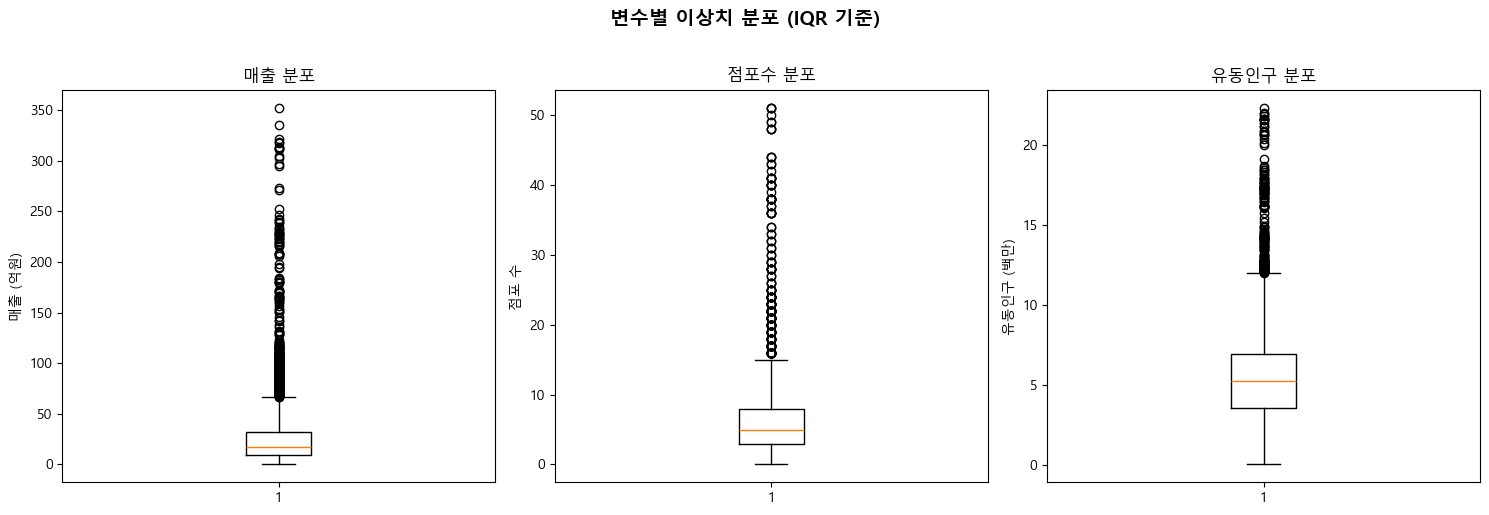

In [13]:
# 이상치 시각화 (박스플롯)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].boxplot(df['당월_매출_금액']/1e8)
axes[0].set_ylabel('매출 (억원)')
axes[0].set_title('매출 분포')

axes[1].boxplot(df['점포_수'])
axes[1].set_ylabel('점포 수')
axes[1].set_title('점포수 분포')

axes[2].boxplot(df['총_유동인구_수']/1e6)
axes[2].set_ylabel('유동인구 (백만)')
axes[2].set_title('유동인구 분포')

plt.suptitle('변수별 이상치 분포 (IQR 기준)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./outputs/02_이상치분석_박스플롯.png', dpi=150, bbox_inches='tight')
plt.show()

## 3.10 중복 데이터 확인

In [14]:
# 중복 확인
dup_count = df.duplicated(subset=['기준_년분기_코드', '행정동_코드']).sum()
print(f"중복 행: {dup_count}건")
if dup_count > 0:
    df = df.drop_duplicates(subset=['기준_년분기_코드', '행정동_코드'])
    print(f"→ 중복 제거 완료")
else:
    print("→ 중복 없음 ✓")

중복 행: 0건
→ 중복 없음 ✓


## 3.11 데이터 정합성 체크

In [15]:
# 정합성 체크
print("[연도별 건수]")
for year, cnt in df.groupby('연도').size().items():
    print(f"  {year}년: {cnt:,}건")

print("\n[분기별 건수]")
quarter_counts = df.groupby('기준_년분기_코드').size()
for qcode, cnt in quarter_counts.items():
    print(f"  {qcode//10}Q{qcode%10}: {cnt:,}건")

variation = (quarter_counts.max() - quarter_counts.min()) / quarter_counts.min() * 100
print(f"\n변동폭: {variation:.1f}%")
print("→ 데이터 균등 분포 ✓" if variation < 10 else "→ 데이터 불균등 ⚠️")

[연도별 건수]
  2022년: 1,635건
  2023년: 1,628건
  2024년: 1,619건
  2025년: 1,215건

[분기별 건수]
  2022Q1: 409건
  2022Q2: 408건
  2022Q3: 409건
  2022Q4: 409건
  2023Q1: 408건
  2023Q2: 407건
  2023Q3: 407건
  2023Q4: 406건
  2024Q1: 406건
  2024Q2: 405건
  2024Q3: 404건
  2024Q4: 404건
  2025Q1: 404건
  2025Q2: 404건
  2025Q3: 407건

변동폭: 1.2%
→ 데이터 균등 분포 ✓


## 3.12 최종 데이터 저장

In [16]:
# 최종 데이터 저장
import os
os.makedirs('./data/processed', exist_ok=True)
df.to_csv('./data/processed/분석데이터.csv', encoding='utf-8-sig', index=False)

print("=" * 70)
print("전처리 완료")
print("=" * 70)
print(f"  저장 경로: ./data/processed/분석데이터.csv")
print(f"  데이터 크기: {len(df):,}건 × {len(df.columns)}열")
print(f"  기간: {df['기준_년분기_코드'].min()} ~ {df['기준_년분기_코드'].max()}")
print(f"\n[상권유형 분포]")
for stype, cnt in df['주요_상권유형'].value_counts().items():
    print(f"  {stype}: {cnt:,}건 ({cnt/len(df)*100:.1f}%)")

전처리 완료
  저장 경로: ./data/processed/분석데이터.csv
  데이터 크기: 6,097건 × 10열
  기간: 20221 ~ 20253

[상권유형 분포]
  골목상권: 5,137건 (84.3%)
  미분류: 339건 (5.6%)
  발달상권: 300건 (4.9%)
  전통시장: 231건 (3.8%)
  관광특구: 90건 (1.5%)


In [17]:
# 최종 데이터 샘플
df.head()

,기준_년분기_코드,행정동_코드,행정동_코드_명,당월_매출_금액,당월_매출_건수,점포_수,총_유동인구_수,주요_상권유형,연도,분기
0,20221,11110515,청운효자동,"1,202,573,186.00",179263,4,3627519,골목상권,2022,1
1,20221,11110530,사직동,"3,761,850,443.00",659962,4,3402653,골목상권,2022,1
2,20221,11110540,삼청동,"1,226,802,003.00",138702,1,821735,발달상권,2022,1
3,20221,11110550,부암동,"607,056,495.00",79978,2,1283546,골목상권,2022,1
4,20221,11110560,평창동,"568,959,905.00",72916,3,823714,골목상권,2022,1


---

# 4. 탐색적 데이터 분석 (EDA) 및 가설 검증

전처리 완료된 데이터를 기반으로 가설 검증을 위한 탐색적 분석 수행

## 4.1 종속변수 탐색: 매출 분포

In [18]:
sales = df['당월_매출_금액']

print("=" * 60)
print("종속변수(Y): 당월 매출 금액")
print("=" * 60)
print(f'''
[기초 통계량]
  평균: {sales.mean()/1e8:.2f}억원
  중앙값: {sales.median()/1e8:.2f}억원
  표준편차: {sales.std()/1e8:.2f}억원
  최소: {sales.min()/1e8:.2f}억원
  최대: {sales.max()/1e8:.2f}억원

[분포 특성]
  왜도(Skewness): {sales.skew():.2f}
  첨도(Kurtosis): {sales.kurtosis():.2f}
''')

if sales.skew() > 1:
    print("  → 오른쪽 꼬리가 긴 분포 (고매출 지역이 소수 존재)")
    print("  → 이분산(Heteroscedasticity) 가능성 → Robust SE 사용 권장")

종속변수(Y): 당월 매출 금액

[기초 통계량]
  평균: 27.11억원
  중앙값: 17.19억원
  표준편차: 32.01억원
  최소: 0.00억원
  최대: 351.91억원

[분포 특성]
  왜도(Skewness): 3.92
  첨도(Kurtosis): 23.46

  → 오른쪽 꼬리가 긴 분포 (고매출 지역이 소수 존재)
  → 이분산(Heteroscedasticity) 가능성 → Robust SE 사용 권장


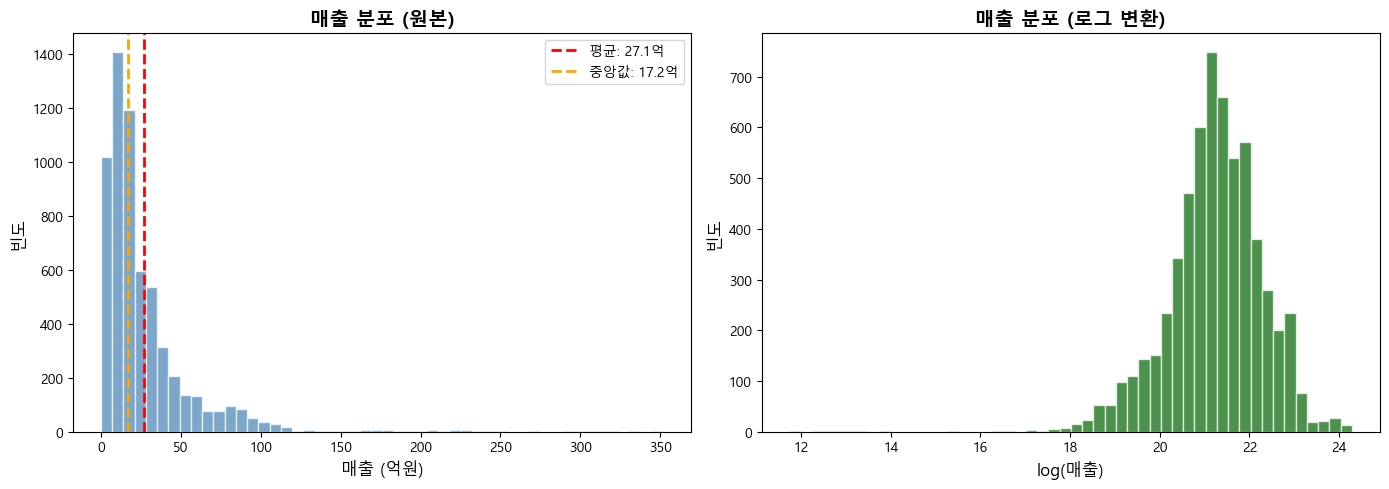

In [19]:
# 매출 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 원본 분포
axes[0].hist(df['당월_매출_금액']/1e8, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].axvline(sales.mean()/1e8, color='red', linestyle='--', linewidth=2, label=f'평균: {sales.mean()/1e8:.1f}억')
axes[0].axvline(sales.median()/1e8, color='orange', linestyle='--', linewidth=2, label=f'중앙값: {sales.median()/1e8:.1f}억')
axes[0].set_xlabel('매출 (억원)', fontsize=12)
axes[0].set_ylabel('빈도', fontsize=12)
axes[0].set_title('매출 분포 (원본)', fontsize=14, fontweight='bold')
axes[0].legend()

# 로그 변환 분포
axes[1].hist(np.log1p(df['당월_매출_금액']), bins=50, color='darkgreen', edgecolor='white', alpha=0.7)
axes[1].set_xlabel('log(매출)', fontsize=12)
axes[1].set_ylabel('빈도', fontsize=12)
axes[1].set_title('매출 분포 (로그 변환)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./outputs/01_매출분포.png', dpi=150, bbox_inches='tight')
plt.show()

## 4.1 분기별 매출 추이

**시계열 트렌드 분석**: 2022년 1분기 ~ 2025년 3분기
- 시간에 따른 매출 변화 패턴 파악
- 상권유형별 성장/하락 추세 비교

In [20]:
# ============================================================
# 분기별 매출 추이 분석
# ============================================================
# 목적: 시간에 따른 매출 변화 패턴 파악
# - 전체 평균 매출 추이
# - 상권유형별 추이 비교
# ============================================================

print("=" * 70)
print("분기별 매출 추이 분석")
print("=" * 70)

# 분기별 평균 매출 계산
quarterly = df.groupby('기준_년분기_코드').agg({
    '당월_매출_금액': ['mean', 'sum', 'count']
}).reset_index()
quarterly.columns = ['기준_년분기_코드', '평균_매출', '총_매출', '행정동_수']

# 분기 라벨 생성 (예: 20221 → 2022Q1)
quarterly['분기'] = quarterly['기준_년분기_코드'].apply(lambda x: f"{x//10}Q{x%10}")

print("\n[분기별 평균 매출 현황]")
print(f"{'분기':<10} {'평균매출(억)':<12} {'행정동수':<10}")
print("-" * 35)
for _, row in quarterly.iterrows():
    print(f"{row['분기']:<10} {row['평균_매출']/1e8:<12.2f} {row['행정동_수']:<10.0f}")

# 성장률 계산
first_q = quarterly.iloc[0]['평균_매출']
last_q = quarterly.iloc[-1]['평균_매출']
growth_rate = (last_q / first_q - 1) * 100

print(f"\n[전체 기간 성장률]")
print(f"  시작({quarterly.iloc[0]['분기']}): {first_q/1e8:.2f}억원")
print(f"  종료({quarterly.iloc[-1]['분기']}): {last_q/1e8:.2f}억원")
print(f"  성장률: {growth_rate:+.1f}%")

분기별 매출 추이 분석

[분기별 평균 매출 현황]
분기         평균매출(억)      행정동수      
-----------------------------------
2022Q1     25.11        409       
2022Q2     27.94        408       
2022Q3     29.12        409       
2022Q4     27.77        409       
2023Q1     26.14        408       
2023Q2     28.82        407       
2023Q3     29.11        407       
2023Q4     27.36        406       
2024Q1     25.49        406       
2024Q2     27.74        405       
2024Q3     27.99        404       
2024Q4     26.55        404       
2025Q1     23.82        404       
2025Q2     26.40        404       
2025Q3     27.28        407       

[전체 기간 성장률]
  시작(2022Q1): 25.11억원
  종료(2025Q3): 27.28억원
  성장률: +8.6%


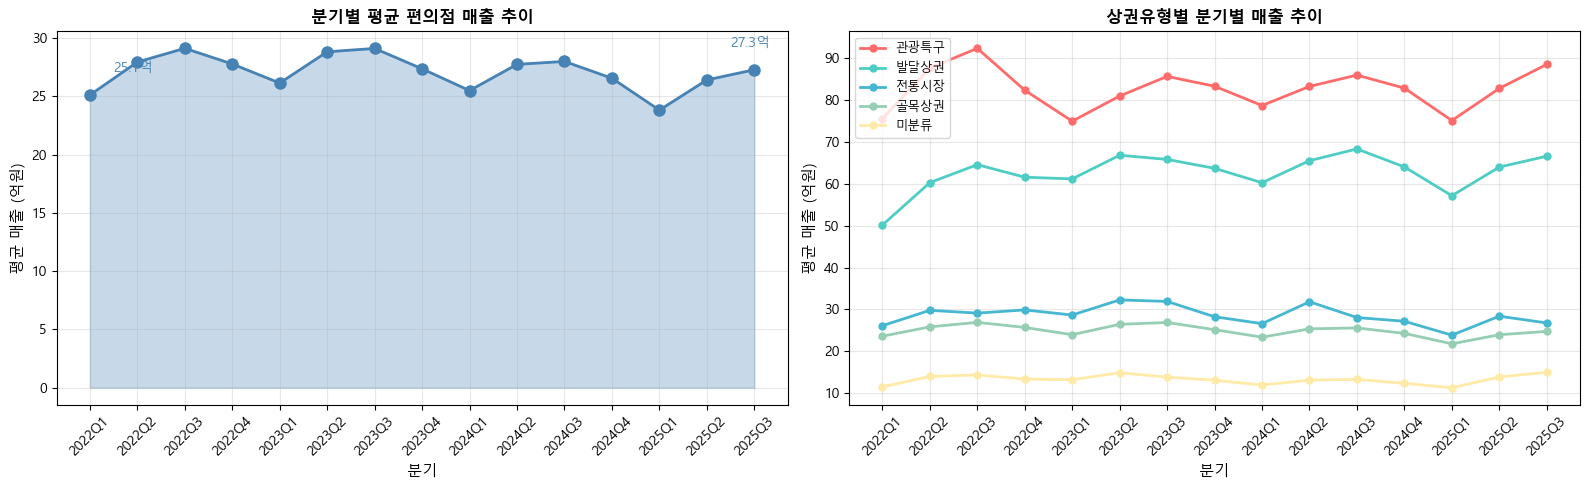

→ 저장: ./outputs/03_분기별_매출추이.png


In [21]:
# ============================================================
# 분기별 매출 추이 시각화
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ------------------------------------------------------------
# 1) 전체 분기별 평균 매출 추이
# ------------------------------------------------------------
ax1 = axes[0]
ax1.plot(quarterly['분기'], quarterly['평균_매출']/1e8, 
         marker='o', linewidth=2, markersize=8, color='steelblue')
ax1.fill_between(range(len(quarterly)), quarterly['평균_매출']/1e8, 
                 alpha=0.3, color='steelblue')

ax1.set_xlabel('분기', fontsize=11)
ax1.set_ylabel('평균 매출 (억원)', fontsize=11)
ax1.set_title('분기별 평균 편의점 매출 추이', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(alpha=0.3)

# 시작/종료 값 표시
ax1.annotate(f'{quarterly.iloc[0]["평균_매출"]/1e8:.1f}억', 
             xy=(0, quarterly.iloc[0]['평균_매출']/1e8), 
             xytext=(0.5, quarterly.iloc[0]['평균_매출']/1e8 + 2),
             fontsize=10, color='steelblue')
ax1.annotate(f'{quarterly.iloc[-1]["평균_매출"]/1e8:.1f}억', 
             xy=(len(quarterly)-1, quarterly.iloc[-1]['평균_매출']/1e8),
             xytext=(len(quarterly)-1.5, quarterly.iloc[-1]['평균_매출']/1e8 + 2),
             fontsize=10, color='steelblue')

# ------------------------------------------------------------
# 2) 상권유형별 분기별 추이
# ------------------------------------------------------------
ax2 = axes[1]

# 상권유형별 분기별 평균 매출
type_quarterly = df.groupby(['기준_년분기_코드', '주요_상권유형'])['당월_매출_금액'].mean().reset_index()
type_quarterly['분기'] = type_quarterly['기준_년분기_코드'].apply(lambda x: f"{x//10}Q{x%10}")

# 색상 설정
colors = {'관광특구': '#FF6B6B', '발달상권': '#4ECDC4', '전통시장': '#45B7D1', 
          '골목상권': '#96CEB4', '미분류': '#FFEAA7'}

for stype in ['관광특구', '발달상권', '전통시장', '골목상권', '미분류']:
    data = type_quarterly[type_quarterly['주요_상권유형'] == stype]
    if len(data) > 0:
        ax2.plot(data['분기'], data['당월_매출_금액']/1e8, 
                 marker='o', linewidth=2, markersize=5, 
                 label=stype, color=colors.get(stype, 'gray'))

ax2.set_xlabel('분기', fontsize=11)
ax2.set_ylabel('평균 매출 (억원)', fontsize=11)
ax2.set_title('상권유형별 분기별 매출 추이', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/03_분기별_매출추이.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 저장: ./outputs/03_분기별_매출추이.png")

## 4.2 가설 H1 검증: 유동인구 → 매출

**H1: 행정동별 총 유동인구가 많을수록 해당 행정동의 매출이 높다**

In [22]:
# 상관관계 분석
corr_h1, pval_h1 = stats.pearsonr(df['총_유동인구_수'], df['당월_매출_금액'])

print("=" * 60)
print("H1 검증: 유동인구 → 매출")
print("=" * 60)
print(f'''
[상관분석 결과]
  Pearson 상관계수: r = {corr_h1:.4f}
  p-value: {pval_h1:.2e}
  
[결론] H1 채택: 행정동별 총 유동인구가 많을수록 해당 행정동의 매출이 높다 (p < 0.001)
''')

H1 검증: 유동인구 → 매출

[상관분석 결과]
  Pearson 상관계수: r = 0.4991
  p-value: 0.00e+00

[결론] H1 채택: 행정동별 총 유동인구가 많을수록 해당 행정동의 매출이 높다 (p < 0.001)



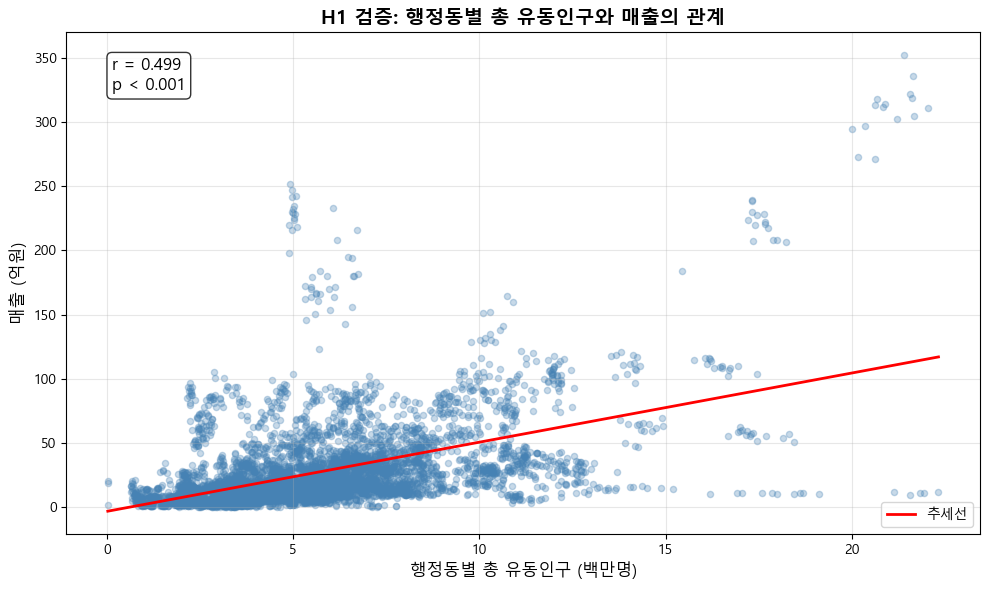

In [23]:
# H1 시각화
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(df['총_유동인구_수']/1e6, df['당월_매출_금액']/1e8, alpha=0.3, s=20, color='steelblue')

# 추세선
z = np.polyfit(df['총_유동인구_수'], df['당월_매출_금액'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['총_유동인구_수'].min(), df['총_유동인구_수'].max(), 100)
ax.plot(x_line/1e6, p(x_line)/1e8, color='red', linewidth=2, label='추세선')

ax.text(0.05, 0.95, f'r = {corr_h1:.3f}\np < 0.001', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('행정동별 총 유동인구 (백만명)', fontsize=12)
ax.set_ylabel('매출 (억원)', fontsize=12)
ax.set_title('H1 검증: 행정동별 총 유동인구와 매출의 관계', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/02_H1_행정동별_총_유동인구_매출.png', dpi=150, bbox_inches='tight')
plt.show()

## 4.3 가설 H2 검증: 점포수 → 매출

**H2: 행정동별 점포수가 많을수록 해당 행정동의 당월 매출이 높다**

> ⚠️ **주의**: 역인과 가능성 존재 (수요가 있는 곳에 점포가 많이 생김)

In [24]:
# 상관관계 분석
corr_h2, pval_h2 = stats.pearsonr(df['점포_수'], df['당월_매출_금액'])

print("=" * 60)
print("H2 검증: 점포수 → 매출")
print("=" * 60)
print(f'''
[상관분석 결과]
  Pearson 상관계수: r = {corr_h2:.4f}
  p-value: {pval_h2:.2e}
  
[결론] H2 채택: 행정동별 점포수가 많을수록 해당 행정동의 당월 매출이 높다 (p < 0.001)

[주의] 상관관계 ≠ 인과관계 (역인과 가능성)
''')

H2 검증: 점포수 → 매출

[상관분석 결과]
  Pearson 상관계수: r = 0.8065
  p-value: 0.00e+00

[결론] H2 채택: 행정동별 점포수가 많을수록 해당 행정동의 당월 매출이 높다 (p < 0.001)

[주의] 상관관계 ≠ 인과관계 (역인과 가능성)



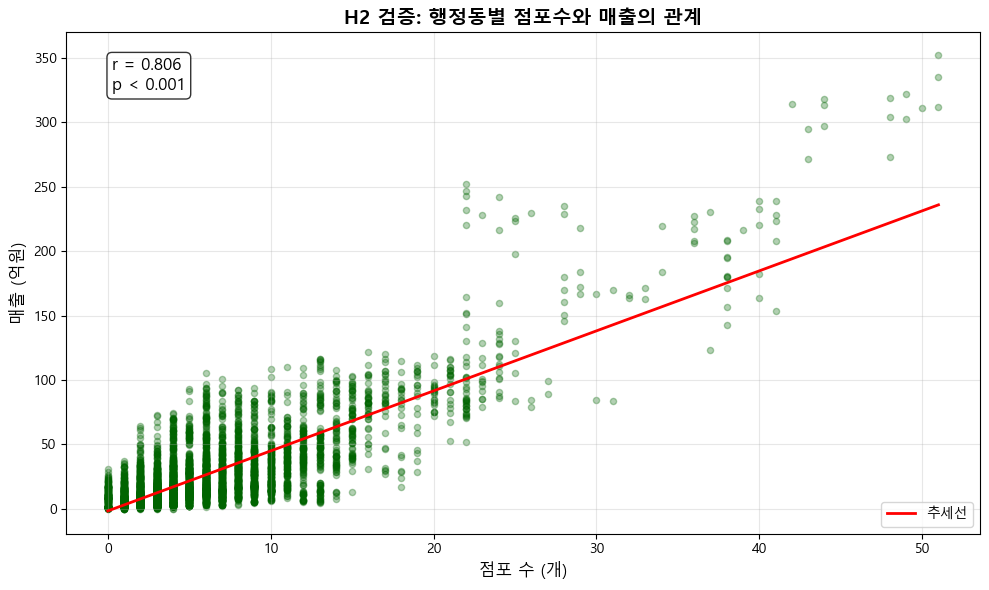

In [25]:
# H2 시각화
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(df['점포_수'], df['당월_매출_금액']/1e8, alpha=0.3, s=20, color='darkgreen')

z = np.polyfit(df['점포_수'], df['당월_매출_금액'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['점포_수'].min(), df['점포_수'].max(), 100)
ax.plot(x_line, p(x_line)/1e8, color='red', linewidth=2, label='추세선')

ax.text(0.05, 0.95, f'r = {corr_h2:.3f}\np < 0.001', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('점포 수 (개)', fontsize=12)
ax.set_ylabel('매출 (억원)', fontsize=12)
ax.set_title('H2 검증: 행정동별 점포수와 매출의 관계', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/03_H2_행정동별_점포수_매출.png', dpi=150, bbox_inches='tight')
plt.show()

## 4.4 사전 점검: 다중공선성 (유동인구 ↔ 점포수)

In [26]:
# 독립변수 간 상관관계
corr_x1x2, pval_x1x2 = stats.pearsonr(df['총_유동인구_수'], df['점포_수'])

print("=" * 60)
print("사전 점검: 다중공선성")
print("=" * 60)
print(f'''
[유동인구 ↔ 점포수 상관계수]
  r = {corr_x1x2:.4f}

[판단]
  r < 0.7 → 다중공선성 문제 낮음 ✓
  → VIF 분석으로 최종 확인 예정
''')

사전 점검: 다중공선성

[유동인구 ↔ 점포수 상관계수]
  r = 0.4848

[판단]
  r < 0.7 → 다중공선성 문제 낮음 ✓
  → VIF 분석으로 최종 확인 예정



## 4.5 가설 H4 검증: 상권유형 간 매출 차이 (ANOVA)

**H4: 상권유형 간 평균 매출 차이가 있다**

In [27]:
# 상권유형별 통계
print("=" * 60)
print("H4 검증: 상권유형별 매출 차이")
print("=" * 60)

type_stats = df.groupby('주요_상권유형')['당월_매출_금액'].agg(['mean', 'median', 'count'])
type_stats['mean_억'] = type_stats['mean'] / 1e8
type_stats = type_stats.sort_values('mean', ascending=False)

print("\n[상권유형별 매출 현황]")
for idx, row in type_stats.iterrows():
    print(f"  {idx}: 평균 {row['mean_억']:.2f}억원 (n={row['count']:.0f})")

H4 검증: 상권유형별 매출 차이

[상권유형별 매출 현황]
  관광특구: 평균 82.61억원 (n=90)
  발달상권: 평균 62.63억원 (n=300)
  전통시장: 평균 28.53억원 (n=231)
  골목상권: 평균 24.91억원 (n=5137)
  미분류: 평균 13.28억원 (n=339)


In [28]:
# ANOVA 검정
groups = [group['당월_매출_금액'].values for name, group in df.groupby('주요_상권유형')]
f_stat, anova_pval = stats.f_oneway(*groups)

print(f'''
[ANOVA 검정 결과]
  F-통계량: {f_stat:.2f}
  p-value: {anova_pval:.2e}
  
[결론] H4 채택: 상권유형 간 매출 차이가 유의함 (p < 0.001)
''')

# 골목상권 대비 차이
base_mean = df[df['주요_상권유형'] == '골목상권']['당월_매출_금액'].mean()
print("[골목상권 대비 매출 차이]")
for t in ['관광특구', '발달상권', '전통시장', '미분류']:
    if t in df['주요_상권유형'].values:
        t_mean = df[df['주요_상권유형'] == t]['당월_매출_금액'].mean()
        diff = (t_mean - base_mean) / 1e8
        print(f"  {t}: {diff:+.2f}억원")


[ANOVA 검정 결과]
  F-통계량: 206.46
  p-value: 2.46e-166

[결론] H4 채택: 상권유형 간 매출 차이가 유의함 (p < 0.001)

[골목상권 대비 매출 차이]
  관광특구: +57.70억원
  발달상권: +37.72억원
  전통시장: +3.62억원
  미분류: -11.63억원


In [29]:
f_stat, anova_pval = stats.f_oneway(*groups)

print(f'''
[ANOVA 검정 결과]
  F-통계량: {f_stat:.2f}
  p-value: {anova_pval:.2e}
  
[결론] H4 채택: 상권유형 간 매출 차이가 유의함 (p < 0.001)
''')

# 골목상권 대비 차이
base_mean = df[df['주요_상권유형'] == '골목상권']['당월_매출_금액'].mean()
print("[골목상권 대비 매출 차이]")
for t in ['관광특구', '발달상권', '전통시장', '미분류']:
    if t in df['주요_상권유형'].values:
        t_mean = df[df['주요_상권유형'] == t]['당월_매출_금액'].mean()
        diff = (t_mean - base_mean) / 1e8
        print(f"  {t}: {diff:+.2f}억원")


[ANOVA 검정 결과]
  F-통계량: 206.46
  p-value: 2.46e-166

[결론] H4 채택: 상권유형 간 매출 차이가 유의함 (p < 0.001)

[골목상권 대비 매출 차이]
  관광특구: +57.70억원
  발달상권: +37.72억원
  전통시장: +3.62억원
  미분류: -11.63억원


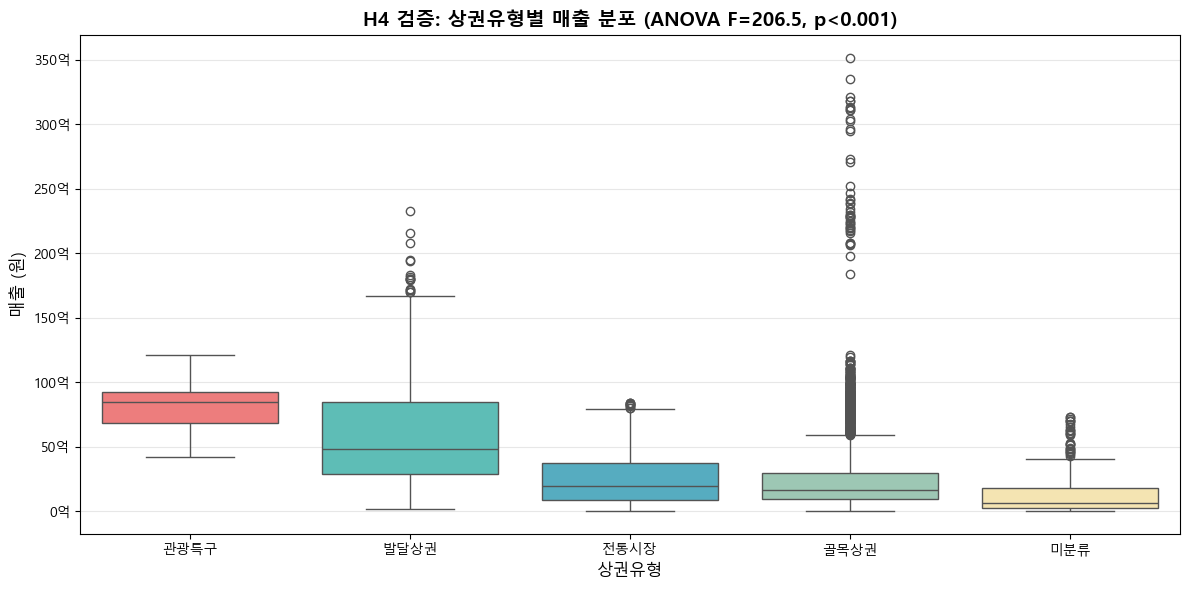

In [30]:
# H4 시각화: 상권유형별 박스플롯
fig, ax = plt.subplots(figsize=(12, 6))

order = type_stats.index.tolist()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

sns.boxplot(data=df, x='주요_상권유형', y='당월_매출_금액', order=order, palette=colors, ax=ax)

ax.set_ylabel('매출 (원)', fontsize=12)
ax.set_xlabel('상권유형', fontsize=12)
ax.set_title(f'H4 검증: 상권유형별 매출 분포 (ANOVA F={f_stat:.1f}, p<0.001)', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e8:.0f}억'))
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./outputs/04_H4_상권유형별_매출.png', dpi=150, bbox_inches='tight')
plt.show()

## 4.6 상관관계 히트맵

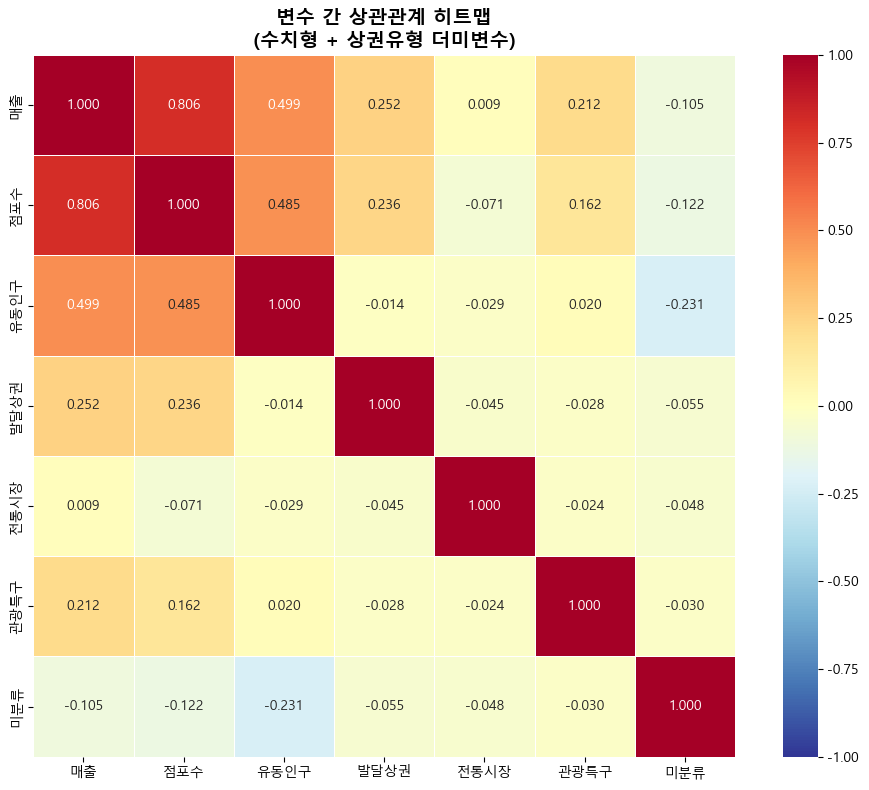


[상관관계 해석]
  매출 vs 유동인구: r = 0.499
  매출 vs 점포수: r = 0.806
  매출 vs 관광특구: r = 0.212
  매출 vs 발달상권: r = 0.252

  ※ 상권유형 더미: 해당 상권=1, 아니면=0 (기준: 골목상권)


In [31]:
# 더미변수 생성 (히트맵용)
df['발달상권'] = (df['주요_상권유형'] == '발달상권').astype(int)
df['전통시장'] = (df['주요_상권유형'] == '전통시장').astype(int)
df['관광특구'] = (df['주요_상권유형'] == '관광특구').astype(int)
df['미분류'] = (df['주요_상권유형'] == '미분류').astype(int)

# 전체 변수 상관관계 (수치형 + 상권유형 더미)
all_cols = ['당월_매출_금액', '점포_수', '총_유동인구_수', '발달상권', '전통시장', '관광특구', '미분류']
corr_matrix = df[all_cols].corr()

# 변수명 한글화
rename_dict = {
    '당월_매출_금액': '매출',
    '점포_수': '점포수',
    '총_유동인구_수': '유동인구',
    '발달상권': '발달상권',
    '전통시장': '전통시장',
    '관광특구': '관광특구',
    '미분류': '미분류'
}
corr_matrix_renamed = corr_matrix.rename(index=rename_dict, columns=rename_dict)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_renamed, annot=True, fmt='.3f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, annot_kws={'size': 10},
            vmin=-1, vmax=1)
ax.set_title('변수 간 상관관계 히트맵\n(수치형 + 상권유형 더미변수)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./outputs/05_상관관계_히트맵.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[상관관계 해석]")
print(f"  매출 vs 유동인구: r = {corr_matrix.loc['당월_매출_금액', '총_유동인구_수']:.3f}")
print(f"  매출 vs 점포수: r = {corr_matrix.loc['당월_매출_금액', '점포_수']:.3f}")
print(f"  매출 vs 관광특구: r = {corr_matrix.loc['당월_매출_금액', '관광특구']:.3f}")
print(f"  매출 vs 발달상권: r = {corr_matrix.loc['당월_매출_금액', '발달상권']:.3f}")
print(f"\n  ※ 상권유형 더미: 해당 상권=1, 아니면=0 (기준: 골목상권)")

## 4.7 가설 검증 종합 (EDA 단계)

In [32]:
print("=" * 70)
print("가설 검증 종합 (EDA 단계)")
print("=" * 70)
print(f"""
┌────────┬──────────────────────────────────┬──────────┬─────────────────┐
│  가설  │               내용               │ 예비결과 │      근거       │
├────────┼──────────────────────────────────┼──────────┼─────────────────┤
│   H1   │ 유동인구↑ → 매출↑                │  지지    │ r={corr_h1:.3f}        │
├────────┼──────────────────────────────────┼──────────┼─────────────────┤
│   H2   │ 점포수↑ → 매출↑                  │  지지    │ r={corr_h2:.3f}        │
├────────┼──────────────────────────────────┼──────────┼─────────────────┤
│   H3   │ 상권유형 → 매출 영향             │  지지    │ 회귀분석 확인   │
├────────┼──────────────────────────────────┼──────────┼─────────────────┤
│   H4   │ 상권유형 간 매출 차이            │  지지    │ F={f_stat:.1f}         │
└────────┴──────────────────────────────────┴──────────┴─────────────────┘
""")

가설 검증 종합 (EDA 단계)

┌────────┬──────────────────────────────────┬──────────┬─────────────────┐
│  가설  │               내용               │ 예비결과 │      근거       │
├────────┼──────────────────────────────────┼──────────┼─────────────────┤
│   H1   │ 유동인구↑ → 매출↑                │  지지    │ r=0.499        │
├────────┼──────────────────────────────────┼──────────┼─────────────────┤
│   H2   │ 점포수↑ → 매출↑                  │  지지    │ r=0.806        │
├────────┼──────────────────────────────────┼──────────┼─────────────────┤
│   H3   │ 상권유형 → 매출 영향             │  지지    │ 회귀분석 확인   │
├────────┼──────────────────────────────────┼──────────┼─────────────────┤
│   H4   │ 상권유형 간 매출 차이            │  지지    │ F=206.5         │
└────────┴──────────────────────────────────┴──────────┴─────────────────┘



---
# 5. 회귀분석

## 5.1 변수 준비

In [33]:
# ============================================================
# 더미변수 생성 (회귀분석용)
# ============================================================
# 범주형 변수(상권유형)를 회귀분석에 사용하려면 숫자로 변환 필요
# 더미변수: 해당 범주이면 1, 아니면 0
# 기준범주: 골목상권 (가장 샘플 수가 많아서 선택)
#          → 다른 상권의 계수는 "골목상권 대비 효과"로 해석
# ============================================================

df['발달상권'] = (df['주요_상권유형'] == '발달상권').astype(int)
df['전통시장'] = (df['주요_상권유형'] == '전통시장').astype(int)
df['관광특구'] = (df['주요_상권유형'] == '관광특구').astype(int)
df['미분류'] = (df['주요_상권유형'] == '미분류').astype(int)

# 독립변수(X)와 종속변수(y) 설정
X = df[['점포_수', '총_유동인구_수', '발달상권', '전통시장', '관광특구', '미분류']]
y = df['당월_매출_금액']

print("[회귀분석 변수 설정]")
print(f"  종속변수(Y): 당월_매출_금액")
print(f"  독립변수(X): {list(X.columns)}")
print(f"  기준범주: 골목상권")
print(f"  관측치 수: {len(X):,}개")

[회귀분석 변수 설정]
  종속변수(Y): 당월_매출_금액
  독립변수(X): ['점포_수', '총_유동인구_수', '발달상권', '전통시장', '관광특구', '미분류']
  기준범주: 골목상권
  관측치 수: 6,097개


## 5.1 다중공선성 검정 (VIF)

In [34]:
# ============================================================
# 다중공선성 검정 (VIF: Variance Inflation Factor)
# ============================================================
# VIF란? 독립변수들 간의 상관관계가 얼마나 높은지 측정
# - VIF < 5: 문제 없음 ✓
# - VIF 5~10: 주의 필요 ⚠️
# - VIF > 10: 심각한 다중공선성 ❌ (변수 제거 고려)
# 
# 다중공선성이 높으면 회귀계수 추정이 불안정해져서
# "어떤 변수가 더 중요한지" 해석이 어려워짐
# ============================================================

# 상수항 추가 (절편 계산용)
X_const = sm.add_constant(X)

# 각 변수별 VIF 계산
vif_data = []
for i, col in enumerate(X_const.columns):
    if col != 'const':  # 상수항은 제외
        vif_val = variance_inflation_factor(X_const.values, i)
        vif_data.append({'변수': col, 'VIF': vif_val})

vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

print("=" * 50)
print("다중공선성 검정 (VIF)")
print("=" * 50)
print("\n[VIF 결과]")
print(vif_df.to_string(index=False))
print(f'''
[해석 기준]
  VIF < 5: 문제 없음 ✓
  VIF 5~10: 주의 ⚠️
  VIF > 10: 심각 ❌
  
[결론] 최대 VIF = {vif_df['VIF'].max():.2f} → 다중공선성 문제 없음 ✓
''')

# 결과 저장
vif_df.to_csv('./outputs/VIF.csv', index=False, encoding='utf-8-sig')

다중공선성 검정 (VIF)

[VIF 결과]
      변수  VIF
    점포_수 1.47
총_유동인구_수 1.41
    발달상권 1.10
     미분류 1.06
    관광특구 1.04
    전통시장 1.01

[해석 기준]
  VIF < 5: 문제 없음 ✓
  VIF 5~10: 주의 ⚠️
  VIF > 10: 심각 ❌

[결론] 최대 VIF = 1.47 → 다중공선성 문제 없음 ✓



## 5.2 OLS 회귀분석 (H1, H2, H3 최종 검증)

In [35]:
# ============================================================
# OLS 회귀분석 (Ordinary Least Squares)
# ============================================================
# cov_type='HC3': Heteroscedasticity-Consistent Standard Errors
# - 이분산(잔차 분산이 일정하지 않음)이 있어도 유효한 표준오차 계산
# - 일반 OLS보다 보수적인 p-value 산출 → 더 신뢰할 수 있음
# ============================================================

X_const = sm.add_constant(X).astype(float)  # 상수항 추가
ols_model = sm.OLS(y.values, X_const.values).fit(cov_type='HC3')  # HC3 Robust SE 적용

print("=" * 70)
print("OLS 회귀분석 결과 (Robust SE - HC3)")
print("=" * 70)
print(f'''
[모델 적합도]
  R² = {ols_model.rsquared:.4f} (설명력: {ols_model.rsquared*100:.1f}%)
  Adj. R² = {ols_model.rsquared_adj:.4f}
  F-statistic = {ols_model.fvalue:.2f} (p = {ols_model.f_pvalue:.2e})
''')

OLS 회귀분석 결과 (Robust SE - HC3)

[모델 적합도]
  R² = 0.6881 (설명력: 68.8%)
  Adj. R² = 0.6878
  F-statistic = 705.62 (p = 0.00e+00)



In [36]:
# 회귀계수 정리
coef_df = pd.DataFrame({
    '변수': X_const.columns,
    '계수': ols_model.params,
    't값': ols_model.tvalues,
    'p값': ols_model.pvalues
})
coef_df['계수(억원)'] = coef_df['계수'] / 1e8
coef_df['유의성'] = coef_df['p값'].apply(lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '')

print("\n[회귀계수]")
print(coef_df[['변수', '계수(억원)', 't값', 'p값', '유의성']].to_string(index=False))
print("\n※ 유의수준: *** p<0.001, ** p<0.01, * p<0.05")

coef_df.to_csv('./outputs/OLS_HC3_계수.csv', index=False, encoding='utf-8-sig')


[회귀계수]
      변수  계수(억원)     t값   p값 유의성
   const   -9.73 -12.09 0.00 ***
    점포_수    3.99  31.77 0.00 ***
총_유동인구_수    0.00  14.33 0.00 ***
    발달상권   14.72  10.37 0.00 ***
    전통시장   11.94  11.54 0.00 ***
    관광특구   27.19  12.94 0.00 ***
     미분류    4.39   4.58 0.00 ***

※ 유의수준: *** p<0.001, ** p<0.01, * p<0.05


## 5.3 잔차 진단

In [37]:
# 잔차 계산
fitted = ols_model.fittedvalues
resid = ols_model.resid

# Breusch-Pagan 이분산 검정
bp_test = het_breuschpagan(resid, X_const.values)
bp_pval = bp_test[1]

print("=" * 50)
print("잔차 진단: 이분산 검정 (Breusch-Pagan)")
print("=" * 50)
print(f'''
[검정 결과]
  LM 통계량: {bp_test[0]:.2f}
  p-value: {bp_pval:.2e}
  
[결론] 이분산 존재 → Robust SE(HC3) 사용이 적절함 ✓
''')

잔차 진단: 이분산 검정 (Breusch-Pagan)

[검정 결과]
  LM 통계량: 1021.86
  p-value: 1.68e-217

[결론] 이분산 존재 → Robust SE(HC3) 사용이 적절함 ✓



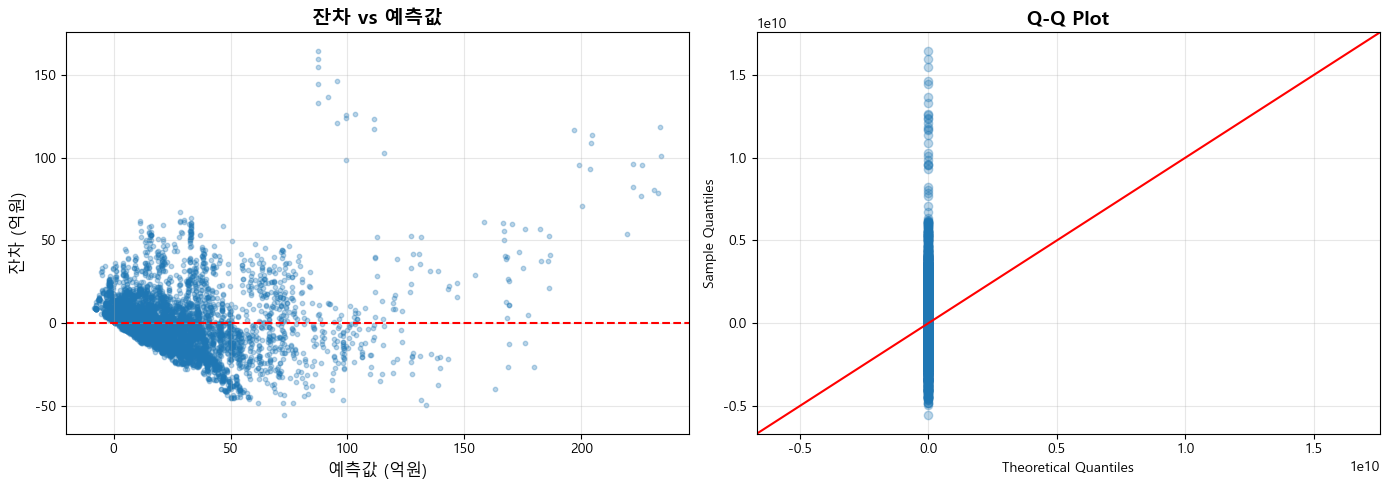

In [38]:
# 잔차 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 잔차 vs 예측값
axes[0].scatter(fitted/1e8, resid/1e8, alpha=0.3, s=10)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1.5)
axes[0].set_xlabel('예측값 (억원)', fontsize=12)
axes[0].set_ylabel('잔차 (억원)', fontsize=12)
axes[0].set_title('잔차 vs 예측값', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# QQ Plot
sm.qqplot(resid, line='45', ax=axes[1], alpha=0.3)
axes[1].set_title('Q-Q Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/06_잔차진단.png', dpi=150, bbox_inches='tight')
plt.show()

## 5.4 사후검정 (Tukey HSD)

In [39]:
# ============================================================
# Tukey HSD 사후검정 (Post-hoc Test)
# ============================================================
# ANOVA는 "차이가 있다"만 알려주고, "어디서" 차이나는지 모름
# Tukey HSD: 모든 그룹 쌍을 비교해서 어떤 쌍이 유의한지 확인
# - reject=True: 두 그룹 간 유의한 차이 있음
# - reject=False: 두 그룹 간 유의한 차이 없음
# ============================================================

tukey = pairwise_tukeyhsd(df['당월_매출_금액'], df['주요_상권유형'], alpha=0.05)

print("=" * 70)
print("Tukey HSD 사후검정")
print("=" * 70)
print(tukey.summary())

# 결과 저장
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
tukey_df.to_csv('./outputs/TukeyHSD.csv', index=False, encoding='utf-8-sig')

Tukey HSD 사후검정
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
group1 group2     meandiff     p-adj       lower            upper       reject
------------------------------------------------------------------------------
  골목상권   관광특구  5770113096.9766    0.0  4898201597.7899  6642024596.1634   True
  골목상권    미분류 -1163054251.8185    0.0 -1622886346.9756  -703222156.6613   True
  골목상권   발달상권   3771815956.391    0.0  3284751487.4614  4258880425.3207   True
  골목상권   전통시장   361650232.9457 0.3799  -189877904.2983   913178370.1897  False
  관광특구    미분류 -6933167348.7951    0.0 -7905533282.5335 -5960801415.0567   True
  관광특구   발달상권 -1998297140.5856    0.0 -2983833416.0478 -1012760865.1233   True
  관광특구   전통시장 -5408462864.0309    0.0 -6427400172.9612 -4389525555.1006   True
   미분류   발달상권  4934870208.2095    0.0   4284872020.847  5584868395.5721   True
   미분류   전통시장  1524704484.7642    0.0   825098071.9486  2224310897.5798   True
  발달상권   전통시장 -3410165723.4453    0.0

## 5.5 표준화 회귀계수 (변수 간 영향력 비교)

**목적**: 서로 다른 단위의 변수들의 상대적 영향력 비교
- 원래 회귀계수: 단위가 달라서 직접 비교 불가 (유동인구 1명 vs 점포 1개)
- 표준화 계수: 모든 변수를 동일 척도로 변환 → 직접 비교 가능
- |β|가 클수록 매출에 더 큰 영향

In [40]:
# ============================================================
# 표준화 회귀계수 (Standardized Coefficients)
# ============================================================
# 목적: 변수 간 상대적 영향력 비교
# - 원래 계수: 유동인구 1명당 효과 vs 점포 1개당 효과 (단위 다름)
# - 표준화 계수: 표준편차 1단위 변화당 효과 (비교 가능)
# - |β|가 클수록 매출에 더 큰 영향을 미침
# ============================================================

print("=" * 70)
print("표준화 회귀계수 (변수 간 영향력 비교)")
print("=" * 70)

# 독립변수 표준화 (평균=0, 표준편차=1로 변환)
X_standardized = (X - X.mean()) / X.std()
X_std_const = sm.add_constant(X_standardized)

# 표준화된 데이터로 회귀분석
model_std = sm.OLS(y.values, X_std_const.values).fit()

# 표준화 계수 추출 (상수항 제외)
std_coefs = pd.DataFrame({
    '변수': X.columns,
    '표준화계수': model_std.params[1:],  # 상수항 제외
    '절대값': np.abs(model_std.params[1:])
}).sort_values('절대값', ascending=False)

print("\n[표준화 회귀계수]")
print(f"{'변수':<15} {'표준화계수':<12} {'영향력 순위':<10}")
print("-" * 40)
for rank, (_, row) in enumerate(std_coefs.iterrows(), 1):
    print(f"{row['변수']:<15} {row['표준화계수']:<+12.4f} {rank}위")

print(f"\n[해석]")
top_var = std_coefs.iloc[0]['변수']
top_coef = std_coefs.iloc[0]['표준화계수']
print(f"  - 가장 영향력 큰 변수: {top_var} (β={top_coef:.4f})")
print(f"  - 해석: {top_var}가 1 표준편차 증가하면 매출이 {top_coef:.4f} 표준편차 변화")

표준화 회귀계수 (변수 간 영향력 비교)

[표준화 회귀계수]
변수              표준화계수        영향력 순위    
----------------------------------------
점포_수            +2214522002.9388 1위
총_유동인구_수        +552016860.7617 2위
관광특구            +327946924.8756 3위
발달상권            +318384794.4086 4위
전통시장            +228008647.8018 5위
미분류             +100700576.5698 6위

[해석]
  - 가장 영향력 큰 변수: 점포_수 (β=2214522002.9388)
  - 해석: 점포_수가 1 표준편차 증가하면 매출이 2214522002.9388 표준편차 변화


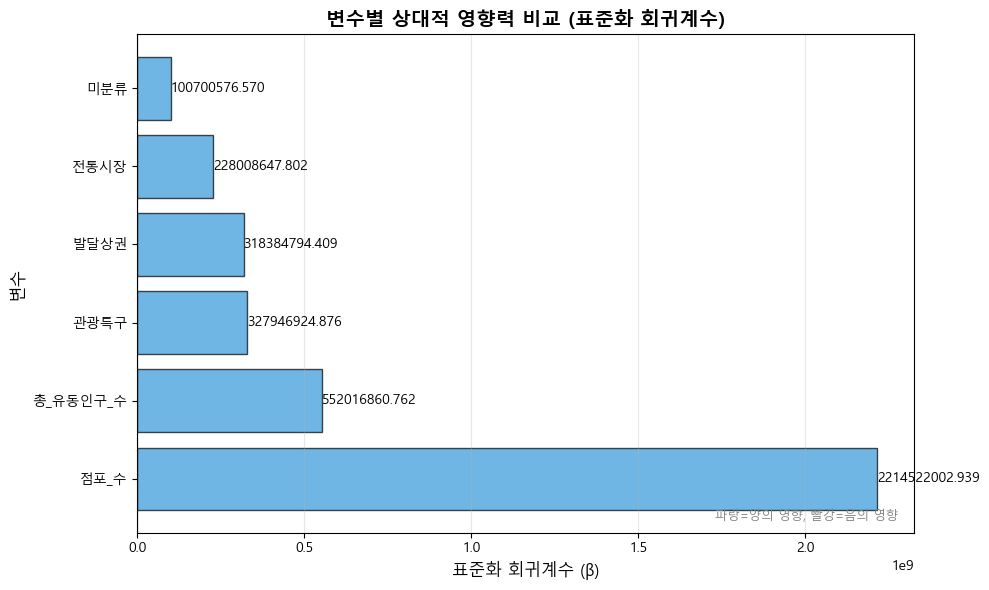

→ 저장: ./outputs/10_표준화_회귀계수.png


In [41]:
# ============================================================
# 표준화 회귀계수 시각화
# ============================================================

fig, ax = plt.subplots(figsize=(10, 6))

# 색상 설정 (양수=파랑, 음수=빨강)
colors = ['#3498db' if c > 0 else '#e74c3c' for c in std_coefs['표준화계수']]

# 수평 막대그래프
bars = ax.barh(std_coefs['변수'], std_coefs['표준화계수'], color=colors, 
               alpha=0.7, edgecolor='black')

# 0 기준선
ax.axvline(x=0, color='black', linewidth=0.8)

# 값 표시
for bar, val in zip(bars, std_coefs['표준화계수']):
    x_pos = val + 0.02 if val > 0 else val - 0.02
    ha = 'left' if val > 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', ha=ha, fontsize=10)

ax.set_xlabel('표준화 회귀계수 (β)', fontsize=12)
ax.set_ylabel('변수', fontsize=12)
ax.set_title('변수별 상대적 영향력 비교 (표준화 회귀계수)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

# 범례
ax.text(0.98, 0.02, '파랑=양의 영향, 빨강=음의 영향', transform=ax.transAxes,
        ha='right', va='bottom', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig('./outputs/10_표준화_회귀계수.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 저장: ./outputs/10_표준화_회귀계수.png")

---
# 6. 머신러닝 예측 모델

## 6.1 모델 학습 및 평가

In [42]:
# ============================================================
# 데이터 분할 (Train/Test Split)
# ============================================================
# - 학습 데이터(80%): 모델 훈련에 사용
# - 테스트 데이터(20%): 모델 성능 평가에 사용
# - random_state=42: 재현 가능성을 위해 시드 고정
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20%를 테스트용으로
    random_state=42     # 랜덤 시드 고정 (재현 가능)
)

print(f"학습 데이터: {len(X_train):,}건")
print(f"테스트 데이터: {len(X_test):,}건")

학습 데이터: 4,877건
테스트 데이터: 1,220건


In [43]:
# ============================================================
# 머신러닝 모델 학습 및 비교
# ============================================================
# 1. Linear Regression (OLS): 해석 용이, 베이스라인
# 2. Random Forest: 앙상블, 비선형 관계 포착, 과적합에 강함
# 3. Gradient Boosting: 앙상블, 순차적 학습, 높은 예측력
# ============================================================

results = []

# ------------------------------------------------------------
# 1) Linear Regression (OLS) - 베이스라인 모델
# ------------------------------------------------------------
X_train_c = sm.add_constant(X_train).astype(float)
X_test_c = sm.add_constant(X_test, has_constant='add').astype(float)
lr_model = sm.OLS(y_train.values, X_train_c.values).fit()
pred_lr = lr_model.predict(X_test_c.values)

results.append({
    '모델': 'Linear (OLS)', 
    'Test R²': r2_score(y_test, pred_lr), 
    'Test MAE': mean_absolute_error(y_test, pred_lr)
})

# ------------------------------------------------------------
# 2) Random Forest - 앙상블 모델 (여러 의사결정나무의 평균)
# ------------------------------------------------------------
rf_model = RandomForestRegressor(
    n_estimators=250,      # 트리 개수
    random_state=42,       # 재현 가능성
    n_jobs=-1,             # 모든 CPU 코어 사용
    min_samples_leaf=2,    # 리프 노드 최소 샘플 수 (과적합 방지)
    oob_score=True         # Out-of-Bag 점수 계산
)
rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict(X_test)

results.append({
    '모델': 'Random Forest', 
    'Test R²': r2_score(y_test, pred_rf),
    'Test MAE': mean_absolute_error(y_test, pred_rf), 
    'OOB R²': rf_model.oob_score_
})

# ------------------------------------------------------------
# 3) Gradient Boosting - 순차적 앙상블 (이전 트리의 오차를 보완)
# ------------------------------------------------------------
gbr_model = GradientBoostingRegressor(
    n_estimators=100,      # 트리 개수
    random_state=42,       # 재현 가능성
    max_depth=5            # 트리 깊이 제한 (과적합 방지)
)
gbr_model.fit(X_train, y_train)
pred_gbr = gbr_model.predict(X_test)

# 5-Fold 교차검증으로 안정성 확인
cv_scores = cross_val_score(gbr_model, X_train, y_train, cv=5, scoring='r2')

results.append({
    '모델': 'Gradient Boosting', 
    'Test R²': r2_score(y_test, pred_gbr),
    'Test MAE': mean_absolute_error(y_test, pred_gbr), 
    'CV R²': cv_scores.mean()
})

# ------------------------------------------------------------
# 결과 정리
# ------------------------------------------------------------
results_df = pd.DataFrame(results)
results_df['Test MAE(억)'] = results_df['Test MAE'] / 1e8

print("=" * 70)
print("모델 성능 비교")
print("=" * 70)
print(results_df[['모델', 'Test R²', 'Test MAE(억)']].to_string(index=False))
print(f'''
[결론]
  - Random Forest가 Test R²={r2_score(y_test, pred_rf):.4f}로 최고 성능
  - 해석: Linear (OLS), 예측: Random Forest 권장
''')

# 결과 저장
results_df.to_csv('./outputs/모델성능_비교.csv', index=False, encoding='utf-8-sig')

모델 성능 비교
               모델  Test R²  Test MAE(억)
     Linear (OLS)     0.72        12.67
    Random Forest     0.86         8.86
Gradient Boosting     0.86         9.12

[결론]
  - Random Forest가 Test R²=0.8633로 최고 성능
  - 해석: Linear (OLS), 예측: Random Forest 권장



## 6.1 Feature Importance

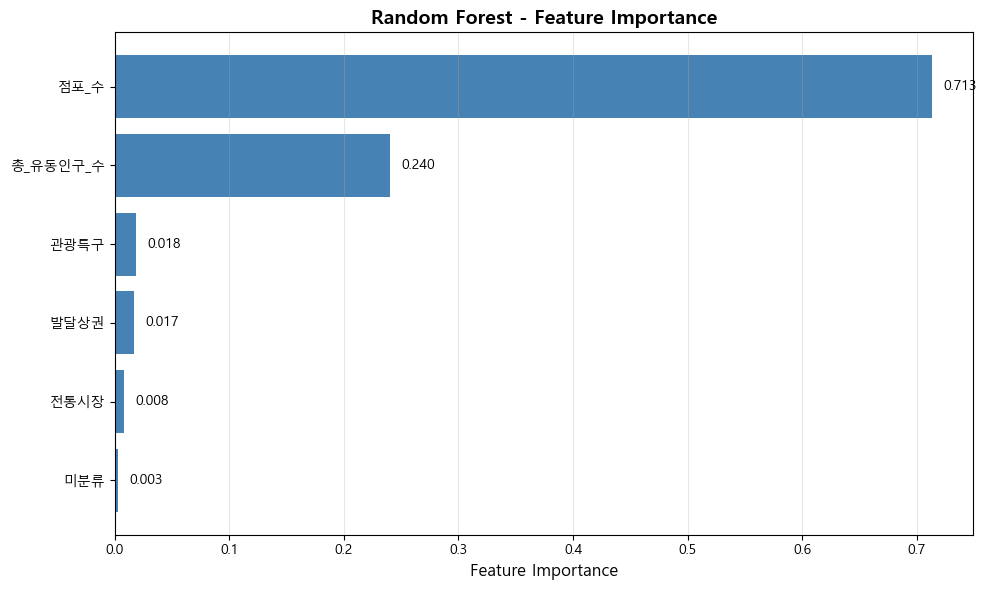

In [44]:
# Feature Importance
importance_df = pd.DataFrame({
    '변수': X.columns,
    '중요도': rf_model.feature_importances_
}).sort_values('중요도', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(importance_df['변수'], importance_df['중요도'], color='steelblue')
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

for bar, val in zip(bars, importance_df['중요도']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('./outputs/07_RF_Feature_Importance.png', dpi=150, bbox_inches='tight')
plt.show()

importance_df.to_csv('./outputs/RF_중요도.csv', index=False, encoding='utf-8-sig')

## 6.2 예측 vs 실제

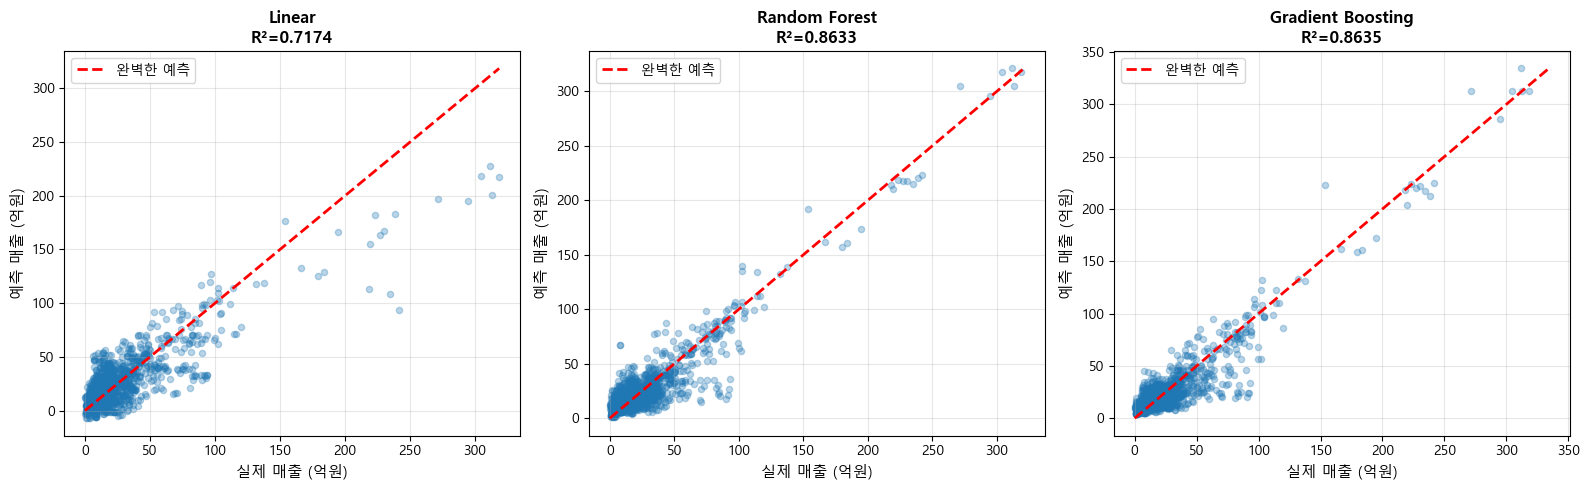

In [45]:
# 예측 vs 실제 산점도
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = [('Linear', pred_lr), ('Random Forest', pred_rf), ('Gradient Boosting', pred_gbr)]

for ax, (name, pred) in zip(axes, models):
    r2 = r2_score(y_test, pred)
    ax.scatter(y_test/1e8, pred/1e8, alpha=0.3, s=20)
    max_val = max(y_test.max(), pred.max()) / 1e8
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='완벽한 예측')
    ax.set_xlabel('실제 매출 (억원)', fontsize=11)
    ax.set_ylabel('예측 매출 (억원)', fontsize=11)
    ax.set_title(f'{name}\nR²={r2:.4f}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/08_예측vs실제_비교.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 7. What-if 시나리오 분석

In [46]:
# 기준 조건
mean_stores = df['점포_수'].mean()
mean_pop = df['총_유동인구_수'].mean()

base_X = np.array([[1, mean_stores, mean_pop, 0, 0, 0, 0]])
base_pred = lr_model.predict(base_X)[0]

print("=" * 50)
print("What-if 시나리오")
print("=" * 50)
print(f'''
[기준 조건] 평균적인 골목상권
  - 점포 수: {mean_stores:.1f}개
  - 유동인구: {mean_pop/1e6:.2f}백만명
  - 기준 예측 매출: {base_pred/1e8:.2f}억원
''')

# 상권유형 전환 효과
print("[상권유형 전환 효과]")
type_dummies = {'골목상권': [0,0,0,0], '발달상권': [1,0,0,0], '전통시장': [0,1,0,0], 
                '관광특구': [0,0,1,0], '미분류': [0,0,0,1]}

for type_name, dummies in type_dummies.items():
    new_X = np.array([[1, mean_stores, mean_pop] + dummies])
    new_pred = lr_model.predict(new_X)[0]
    change = new_pred - base_pred
    print(f"  {type_name}: {new_pred/1e8:.2f}억원 (골목 대비 {change/1e8:+.2f}억)")

What-if 시나리오

[기준 조건] 평균적인 골목상권
  - 점포 수: 6.2개
  - 유동인구: 5.62백만명
  - 기준 예측 매출: 25.16억원

[상권유형 전환 효과]
  골목상권: 25.16억원 (골목 대비 +0.00억)
  발달상권: 40.23억원 (골목 대비 +15.06억)
  전통시장: 37.43억원 (골목 대비 +12.27억)
  관광특구: 53.49억원 (골목 대비 +28.33억)
  미분류: 29.60억원 (골목 대비 +4.44억)


---
# 8. 비즈니스 인사이트

## 8.1 저평가/고평가 지역 분석

In [47]:
# ============================================================
# 저평가/고평가 지역 분석을 위한 잔차 계산
# ============================================================
# 잔차(Residual) = 실제값 - 예측값
# - 잔차 < 0 (음수): 저평가 지역 (조건 대비 매출 낮음) → 개선 기회
# - 잔차 > 0 (양수): 고평가 지역 (조건 대비 매출 높음) → 벤치마킹 대상
# ============================================================

# 전체 데이터에 예측값 추가
X_full = sm.add_constant(X).astype(float)
df['예측_매출'] = lr_model.predict(X_full.values)
df['잔차'] = df['당월_매출_금액'] - df['예측_매출']

# 최근 분기 데이터만 추출 (가장 최신 현황 분석)
latest_qtr = df['기준_년분기_코드'].max()
df_latest = df[df['기준_년분기_코드'] == latest_qtr].copy()

print(f"분석 기준: {latest_qtr//10}년 {latest_qtr%10}분기 ({len(df_latest)}개 행정동)")

분석 기준: 2025년 3분기 (407개 행정동)


In [48]:
# 저평가 지역 TOP 10
print("=" * 70)
print("저평가 지역 TOP 10 (잠재력 높은 지역)")
print("=" * 70)

underperform = df_latest.nsmallest(10, '잔차')[['행정동_코드_명', '주요_상권유형', '점포_수', 
                                                '당월_매출_금액', '예측_매출', '잔차']].copy()
underperform['실제(억)'] = underperform['당월_매출_금액'] / 1e8
underperform['예측(억)'] = underperform['예측_매출'] / 1e8
underperform['차이(억)'] = underperform['잔차'] / 1e8

for _, row in underperform.iterrows():
    print(f"  {row['행정동_코드_명']:<12} {row['주요_상권유형']:<8} 실제:{row['실제(억)']:>6.1f}억 예측:{row['예측(억)']:>6.1f}억 차이:{row['차이(억)']:>+6.1f}억")

저평가 지역 TOP 10 (잠재력 높은 지역)
  강일동          골목상권     실제:   7.9억 예측:  51.7억 차이: -43.8억
  상봉1동         골목상권     실제:   7.7억 예측:  50.2억 차이: -42.5억
  신도림동         골목상권     실제:  14.1억 예측:  53.4억 차이: -39.3억
  공덕동          골목상권     실제:  11.4억 예측:  48.6억 차이: -37.2억
  공항동          골목상권     실제:  15.0억 예측:  51.4억 차이: -36.4억
  연희동          골목상권     실제:  28.8억 예측:  61.4억 차이: -32.7억
  구로2동         골목상권     실제:  14.5억 예측:  46.1억 차이: -31.6억
  월계1동         골목상권     실제:  18.2억 예측:  49.7억 차이: -31.4억
  화곡본동         골목상권     실제:  13.8억 예측:  45.0억 차이: -31.2억
  신정4동         골목상권     실제:  46.3억 예측:  76.7억 차이: -30.4억


In [49]:
# 고평가 지역 TOP 10
print("\n" + "=" * 70)
print("고평가 지역 TOP 10 (벤치마킹 대상)")
print("=" * 70)

outperform = df_latest.nlargest(10, '잔차')[['행정동_코드_명', '주요_상권유형', '점포_수',
                                             '당월_매출_금액', '예측_매출', '잔차']].copy()
outperform['실제(억)'] = outperform['당월_매출_금액'] / 1e8
outperform['예측(억)'] = outperform['예측_매출'] / 1e8
outperform['차이(억)'] = outperform['잔차'] / 1e8

for _, row in outperform.iterrows():
    print(f"  {row['행정동_코드_명']:<12} {row['주요_상권유형']:<8} 실제:{row['실제(억)']:>6.1f}억 예측:{row['예측(억)']:>6.1f}억 차이:{row['차이(억)']:>+6.1f}억")


고평가 지역 TOP 10 (벤치마킹 대상)
  가산동          골목상권     실제: 223.4억 예측:  97.3억 차이:+126.2억
  역삼1동         골목상권     실제: 313.6억 예측: 193.2억 차이:+120.4억
  수서동          발달상권     실제:  92.7억 예측:  33.3억 차이: +59.4억
  성수2가3동       골목상권     실제:  91.9억 예측:  32.8억 차이: +59.1억
  서교동          골목상권     실제: 238.6억 예측: 182.6억 차이: +56.0억
  명동           발달상권     실제: 183.6억 예측: 129.2억 차이: +54.4억
  대치4동         발달상권     실제: 164.6억 예측: 111.4억 차이: +53.2억
  일원본동         미분류      실제:  69.8억 예측:  19.1억 차이: +50.7억
  서초2동         골목상권     실제:  84.0억 예측:  42.9억 차이: +41.2억
  화곡1동         골목상권     실제: 109.0억 예측:  68.3억 차이: +40.7억


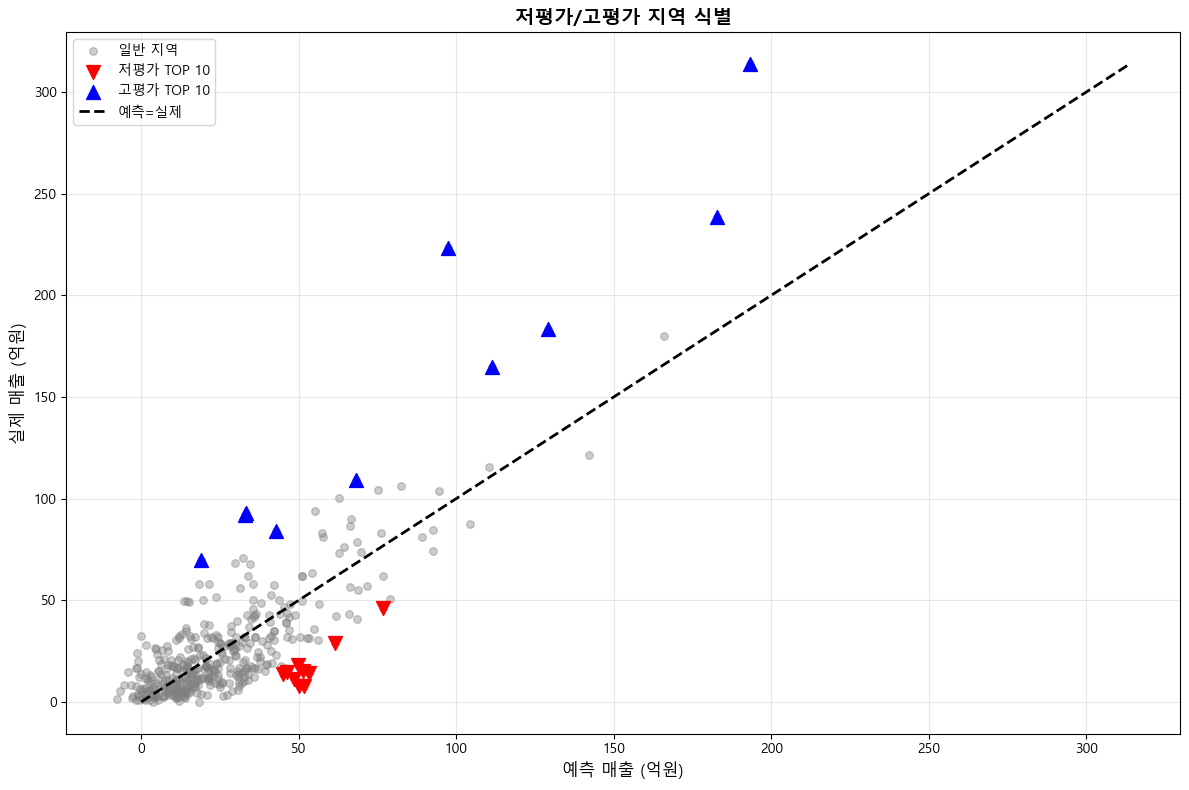

In [50]:
# 저평가/고평가 시각화
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(df_latest['예측_매출']/1e8, df_latest['당월_매출_금액']/1e8, 
           alpha=0.4, s=30, c='gray', label='일반 지역')
ax.scatter(underperform['예측(억)'], underperform['실제(억)'], 
           c='red', s=100, marker='v', label='저평가 TOP 10', zorder=5)
ax.scatter(outperform['예측(억)'], outperform['실제(억)'], 
           c='blue', s=100, marker='^', label='고평가 TOP 10', zorder=5)

max_val = max(df_latest['예측_매출'].max(), df_latest['당월_매출_금액'].max()) / 1e8
ax.plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='예측=실제')

ax.set_xlabel('예측 매출 (억원)', fontsize=12)
ax.set_ylabel('실제 매출 (억원)', fontsize=12)
ax.set_title('저평가/고평가 지역 식별', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/09_저평가_고평가_지역.png', dpi=150, bbox_inches='tight')
plt.show()

## 8.1 핵심 인사이트 정리

In [51]:
print("=" * 70)
print("핵심 인사이트")
print("=" * 70)
print("""
[인사이트 1] 상권유형이 매출의 핵심 결정 요인
  - 관광특구: 골목상권 대비 +27억원
  - 발달상권: 골목상권 대비 +15억원

[인사이트 2] 저평가 지역 = 성장 기회
  - 조건 대비 매출이 낮은 지역 다수 존재
  - 운영 개선 또는 신규 진입 기회

[인사이트 3] 상관관계 ≠ 인과관계
  - 점포수와 매출의 강한 상관 (r=0.81)
  - 그러나 역인과 가능성 존재
""")

핵심 인사이트

[인사이트 1] 상권유형이 매출의 핵심 결정 요인
  - 관광특구: 골목상권 대비 +27억원
  - 발달상권: 골목상권 대비 +15억원

[인사이트 2] 저평가 지역 = 성장 기회
  - 조건 대비 매출이 낮은 지역 다수 존재
  - 운영 개선 또는 신규 진입 기회

[인사이트 3] 상관관계 ≠ 인과관계
  - 점포수와 매출의 강한 상관 (r=0.81)
  - 그러나 역인과 가능성 존재



---
# 9. 결론 및 제언

## 9.1 가설 검증 최종 결과

In [52]:
print("=" * 70)
print("가설 검증 최종 결과")
print("=" * 70)
print(f"""
┌────────┬──────────────────────────────────┬────────┐
│  가설  │               내용               │  결과  │
├────────┼──────────────────────────────────┼────────┤
│   H1   │ 유동인구↑ → 매출↑                │  채택  │
├────────┼──────────────────────────────────┼────────┤
│   H2   │ 점포수↑ → 매출↑                  │  채택  │
├────────┼──────────────────────────────────┼────────┤
│   H3   │ 상권유형 → 매출 영향             │  채택  │
├────────┼──────────────────────────────────┼────────┤
│   H4   │ 상권유형 간 매출 차이            │  채택  │
└────────┴──────────────────────────────────┴────────┘

[모델 성능]
  - OLS R² = {ols_model.rsquared:.4f}
  - Random Forest R² = {r2_score(y_test, pred_rf):.4f}
""")

가설 검증 최종 결과

┌────────┬──────────────────────────────────┬────────┐
│  가설  │               내용               │  결과  │
├────────┼──────────────────────────────────┼────────┤
│   H1   │ 유동인구↑ → 매출↑                │  채택  │
├────────┼──────────────────────────────────┼────────┤
│   H2   │ 점포수↑ → 매출↑                  │  채택  │
├────────┼──────────────────────────────────┼────────┤
│   H3   │ 상권유형 → 매출 영향             │  채택  │
├────────┼──────────────────────────────────┼────────┤
│   H4   │ 상권유형 간 매출 차이            │  채택  │
└────────┴──────────────────────────────────┴────────┘

[모델 성능]
  - OLS R² = 0.6881
  - Random Forest R² = 0.8633



## 9.1 실무적 제언

In [53]:
print("=" * 70)
print("실무적 제언")
print("=" * 70)
print("""
[신규 출점]
  1. 상권유형 우선 확인 (관광특구 > 발달상권 > 전통시장 > 골목상권)
  2. 유동인구 데이터 활용
  3. 점포 밀집 지역은 경쟁 강도 고려

[기존 점포]
  - 발달상권/관광특구: 충동구매 상품, 프리미엄
  - 골목상권: 생활밀착형, 배달서비스
  - 미분류: 야간/새벽 틈새, 부가서비스
""")

실무적 제언

[신규 출점]
  1. 상권유형 우선 확인 (관광특구 > 발달상권 > 전통시장 > 골목상권)
  2. 유동인구 데이터 활용
  3. 점포 밀집 지역은 경쟁 강도 고려

[기존 점포]
  - 발달상권/관광특구: 충동구매 상품, 프리미엄
  - 골목상권: 생활밀착형, 배달서비스
  - 미분류: 야간/새벽 틈새, 부가서비스



## 9.2 분석의 한계

In [54]:
print("=" * 70)
print("분석의 한계")
print("=" * 70)
print("""
[1] 변수 한계: 임대료, 경쟁강도, 브랜드 등 미포함
[2] 분석 단위: 행정동 집계 (개별 점포 수준 아님)
[3] 인과관계 주의: 상관관계 ≠ 인과관계 (역인과 가능성)
[4] 시계열 특성: 패널 고정효과 미적용
""")

분석의 한계

[1] 변수 한계: 임대료, 경쟁강도, 브랜드 등 미포함
[2] 분석 단위: 행정동 집계 (개별 점포 수준 아님)
[3] 인과관계 주의: 상관관계 ≠ 인과관계 (역인과 가능성)
[4] 시계열 특성: 패널 고정효과 미적용



## 9.3 최종 요약

In [55]:
print("=" * 70)
print("최종 요약")
print("=" * 70)
print("""
╔═════════════════════════════════════════════════════════════════╗
║              서울시 편의점 매출 분석 결론                       ║
╠═════════════════════════════════════════════════════════════════╣
║  [핵심 발견]                                                    ║
║    1. 상권유형 > 점포수 > 유동인구 순으로 매출에 영향           ║
║    2. 관광특구/발달상권이 골목상권 대비 현저히 높은 매출        ║
║    3. 모든 가설(H1~H4) 통계적으로 유의하게 채택                 ║
║                                                                 ║
║  [주의사항]                                                     ║
║    • 상관관계 ≠ 인과관계                                        ║
║    • 실제 의사결정 시 현장 검증 필수                            ║
╚═════════════════════════════════════════════════════════════════╝
""")
print("\n분석 완료. 감사합니다.")

최종 요약

╔═════════════════════════════════════════════════════════════════╗
║              서울시 편의점 매출 분석 결론                       ║
╠═════════════════════════════════════════════════════════════════╣
║  [핵심 발견]                                                    ║
║    1. 상권유형 > 점포수 > 유동인구 순으로 매출에 영향           ║
║    2. 관광특구/발달상권이 골목상권 대비 현저히 높은 매출        ║
║    3. 모든 가설(H1~H4) 통계적으로 유의하게 채택                 ║
║                                                                 ║
║  [주의사항]                                                     ║
║    • 상관관계 ≠ 인과관계                                        ║
║    • 실제 의사결정 시 현장 검증 필수                            ║
╚═════════════════════════════════════════════════════════════════╝


분석 완료. 감사합니다.


---
## 생성된 파일 목록

In [56]:
import os

print("=" * 50)
print("생성된 결과 파일")
print("=" * 50)

if os.path.exists('./outputs'):
    output_files = os.listdir('./outputs')
    for f in sorted(output_files):
        size = os.path.getsize(f'./outputs/{f}')
        print(f"  ./outputs/{f} ({size:,} bytes)")

생성된 결과 파일
  ./outputs/01_매출분포.png (50,486 bytes)
  ./outputs/02_H1_유동인구_매출.png (199,638 bytes)
  ./outputs/02_H1_행정동별_총_유동인구_매출.png (204,158 bytes)
  ./outputs/02_이상치분석_박스플롯.png (61,760 bytes)
  ./outputs/03_H2_점포수_매출.png (129,582 bytes)
  ./outputs/03_H2_행정동별_점포수_매출.png (131,577 bytes)
  ./outputs/03_분기별_매출추이.png (121,159 bytes)
  ./outputs/04_H4_상권유형별_매출.png (57,645 bytes)
  ./outputs/05_상관관계_히트맵.png (103,029 bytes)
  ./outputs/06_잔차진단.png (166,690 bytes)
  ./outputs/07_RF_Feature_Importance.png (36,158 bytes)
  ./outputs/08_예측vs실제_비교.png (187,517 bytes)
  ./outputs/09_저평가_고평가_지역.png (115,109 bytes)
  ./outputs/10_표준화_회귀계수.png (53,145 bytes)
  ./outputs/OLS_HC3_계수.csv (730 bytes)
  ./outputs/RF_중요도.csv (231 bytes)
  ./outputs/TukeyHSD.csv (892 bytes)
  ./outputs/VIF.csv (214 bytes)
  ./outputs/모델성능_비교.csv (312 bytes)
